# Model Inference
[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/hsimonfroy/benchmark-field-level/blob/main/examples/infer_model.ipynb)

Infer from a cosmological model via MCMC samplers.

In [1]:
import os; os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.8' # NOTE: jax preallocates GPU (default 75%)
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from jax import numpy as jnp, random as jr, config as jconfig, devices as jdevices, jit, vmap, grad, debug, tree
jconfig.update("jax_enable_x64", True)
print(jdevices())

from montecosmo.model import FieldLevelModel, default_config
from montecosmo.utils import pdump, pload, Path

%matplotlib inline
%load_ext autoreload
%autoreload 2
!hostname
#!jupyter nbconvert --to python /global/u1/h/hsimfroy/workspace/montecosmo_proj/src/montecosmo/tests/infer_model2.ipynb

save_dir = Path("/feynman/home/dphp/hs276503/scratch/png/kaiser_test7")
# save_dir = Path("/pscratch/sd/h/hsimfroy/png/lpt_64_fnl_0")
save_path = save_dir / "test"
save_dir.mkdir(parents=True, exist_ok=True)

[cuda(id=0)]
feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [2]:
import itertools
order = 10
for i in range(6):
    order = i
    ishifts = np.arange(order) - (order - 1) // 2
    print(ishifts)

for ishift in itertools.product(* 3 * (ishifts,)):
    # print(np.array(ishift))
    # print(ishift)
    pass

[]
[0]
[0 1]
[-1  0  1]
[-1  0  1  2]
[-2 -1  0  1  2]


2025-06-01 18:10:52.400957: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


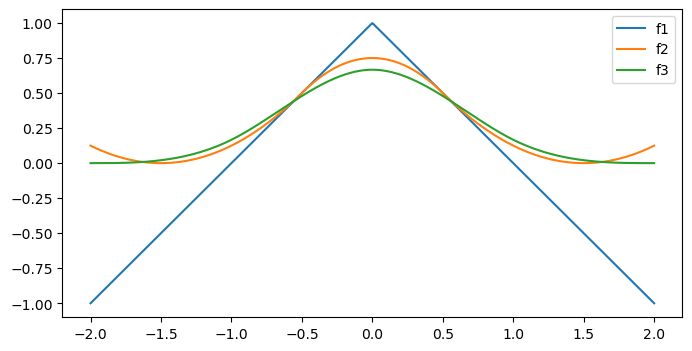

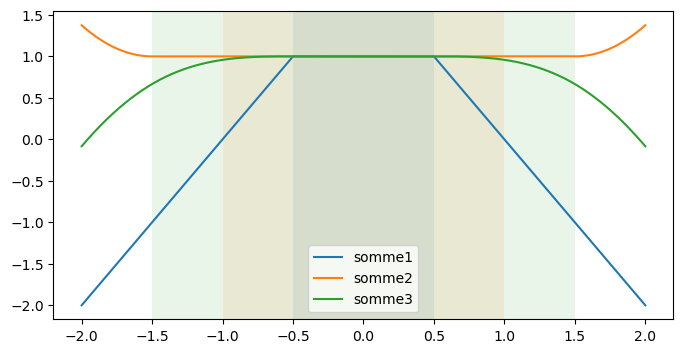

In [2]:
def f1(x):
    s = np.abs(x)
    return 1 - s

def f2(x):
    s = np.abs(x)
    return (s <= 1/2) * (3/4 - s**2) + (s > 1/2) / 2 * (3/2 - s)**2

def f3(x):
    s = np.abs(x)
    return (s <= 1) / 6 * (4 - 6 * s**2 + 3 * s**3) + (s > 1) / 6 * (2 - s)**3

xs = jnp.linspace(-2, 2, 1000)
plt.figure(figsize=(8, 4))
plt.plot(xs, f1(xs), label="f1")
plt.plot(xs, f2(xs), label="f2")
plt.plot(xs, f3(xs), label="f3")
plt.legend()

plt.figure(figsize=(8, 4))
somme1 = lambda xshift: f1(xshift+.5) + f1(xshift-.5)
somme2 = lambda xshift: f2(xshift-1) + f2(xshift + 1) + f2(xshift) 
somme3 = lambda xshift: f3(xshift-1.5) + f3(xshift + 1.5) + f3(xshift+.5) + f3(xshift-.5) 
plt.plot(xs, somme1(xs), label="somme1")
plt.plot(xs, somme2(xs), label="somme2")
plt.plot(xs, somme3(xs), label="somme3")
plt.ylim(plt.ylim())
plt.fill_betweenx(plt.ylim(), -.5, .5, alpha=.1)
plt.fill_betweenx(plt.ylim(), -1, 1, alpha=.1)
plt.fill_betweenx(plt.ylim(), -1.5, 1.5, alpha=.1)
plt.legend()

In [25]:
def get_ptcl_shape(mesh_shape, oversampling=1.):
    return np.round(mesh_shape / oversampling).astype(int)

ptcl_shape = get_ptcl_shape(model.mesh_shape, 1.)
print(model.mesh_shape, model.mesh_shape / ptcl_shape)

ptcl_pos = [np.linspace(0, m, p, endpoint=False) for m, p in zip(model.mesh_shape, ptcl_shape)]
ptcl_pos = np.stack(np.meshgrid(*ptcl_pos, indexing='ij'), axis=-1).reshape(-1, 3)
pos = np.indices(model.mesh_shape, dtype=float).reshape(3,-1).T
pctl_pos = jnp.array(ptcl_pos)
pos = jnp.array(pos)
# pos[0], pos[1] = pos[1], pos[0]
np.allclose(ptcl_pos, pos)

[206 404 202] [1. 1. 1.]


True

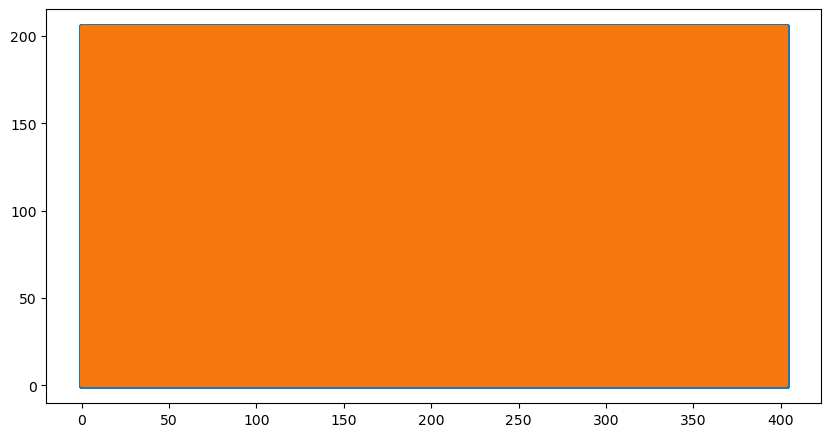

In [26]:
pos = jnp.indices(model.mesh_shape, dtype=float).reshape(3,-1).T
pos.min(0), pos.max(0)
plt.figure(figsize=(10, 8))
plt.scatter(pos[:,1], pos[:,0], marker='x', s=10, alpha=.1)
plt.scatter(ptcl_pos[:,1], ptcl_pos[:,0], marker='+', s=10, alpha=.1)
plt.gca().set_aspect('equal')

## Experimental setup
### Instantiate model
We can see how the model is actually reparametrized.

###  Generate an observation and condition the model on it
We can see all the free parameters in the model, that we will subsequently sample.

In [25]:
# overwrite = False
overwrite = True
truth0 = {'Omega_m': 0.3111, 
    'sigma8': 0.8,
    'b1': 1.,
    'b2': 0., 
    'bs2': 0., 
    'bn2': 0.,
    'bnp': 0.,
    'fNL': 0.,
    'alpha_iso': 1.,
    'alpha_ap': 1.,
    'ngbar': 1e-3,}
cell_budget = 32**3
padding = 0.2
# padding = None
mesh_length = round(cell_budget**(1/3))

if not os.path.exists(save_dir / "truth.npz") or overwrite:
    print("Generate truth...")
    model = FieldLevelModel(**default_config | 
                                {'mesh_shape': 3*(mesh_length,), 
                                'cell_length': 3000 / mesh_length, 
                                'box_center': (0.,0.,2000.), # in Mpc/h
                                'box_rotvec': (0.,0.,0.,), # rotation vector in radians
                                'evolution': 'kaiser',
                                'a_obs': .5, # light-cone if None
                                'curved_sky': False, # curved vs. flat sky
                                'ap_auto': False, # parametrized AP vs. auto AP
                                'window': padding, # if float, padded fraction, if str or Path, path to window mesh file
                                'oversampling': 1.,
                                'paint_order': 2,
                                } )
    
    fits_path = Path("/home/nfs/bao/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    # fits_path = Path("/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/AbacusSummit_v4_2/mock0/LRG_complete_SGC_1_clustering.ran.fits")
    model.add_window(fits_path, cell_budget, padding, save_dir / "window.npy")
    
    truth = model.predict(samples=truth0, hide_base=False, hide_samp=False, hide_det=False, from_base=True)
    model.save(save_dir / "model.yaml")    
    jnp.savez(save_dir / "truth.npz", **truth)

    # model2 = FieldLevelModel(**model.asdict() | {'evolution': 'kaiser', 'window':None})
    # model2 = FieldLevelModel(**model.asdict() | {'ap_auto': None})
    # model2 = FieldLevelModel(**model.asdict() | {'paint_order': 3})
    # model2 = FieldLevelModel(**model.asdict() | {'oversampling': 1.})
    
    model2 = FieldLevelModel(**model.asdict())
    # model2.latents['Omega_m']['loc_fid'] = 0.3
    # model2.__post_init__()

    # truth2 = model2.predict(samples=truth0, hide_base=False, hide_samp=False, from_base=True)
    truth2 = model2.predict(samples=truth0 | {'Omega_m': 0.3}, hide_base=False, hide_samp=False, from_base=True)

    model2.save(save_dir / "model2.yaml")    
    jnp.savez(save_dir / "truth2.npz", **truth2)
else:
    model = FieldLevelModel.load(save_dir / "model.yaml")
    truth = np.load(save_dir / "truth.npz")

    model2 = FieldLevelModel.load(save_dir / "model2.yaml")
    truth2 = np.load(save_dir / "truth2.npz")

print(model)
# model.render()
# delta_obs = model.count2delta(truth['obs'])
delta_obs  = model.count2delta(truth['obs'], from_masked=False)

# print(model2)
# model2.render()
# model2.render("bnet.png")
# delta_obs2 = model2.count2delta(truth2['obs'])
delta_obs2 = model2.count2delta(truth2['obs'], from_masked=False)

Generate truth...
norsd
kai
norsd
norsd
kai
norsd
# CONFIG
{'a_obs': 0.5,
 'ap_auto': False,
 'box_center': array([1365.33215673,  218.00609919,  268.40691564]),
 'box_rotvec': array([0., 0., 0.]),
 'cell_length': 102.515019968137,
 'curved_sky': False,
 'evolution': 'kaiser',
 'latents': {'Omega_m': {'group': 'cosmo',
                         'high': 1.0,
                         'label': '{\\Omega}_m',
                         'loc': 0.3111,
                         'loc_fid': 0.3111,
                         'low': 0.05,
                         'scale': 0.5,
                         'scale_fid': 0.001},
             'alpha_ap': {'group': 'ap',
                          'high': inf,
                          'label': '{\\alpha_\\mathrm{AP}}',
                          'loc': 1.0,
                          'loc_fid': 1.0,
                          'low': 0.0,
                          'scale': 0.1,
                          'scale_fid': 0.01},
             'alpha_iso': {'group': 'ap'

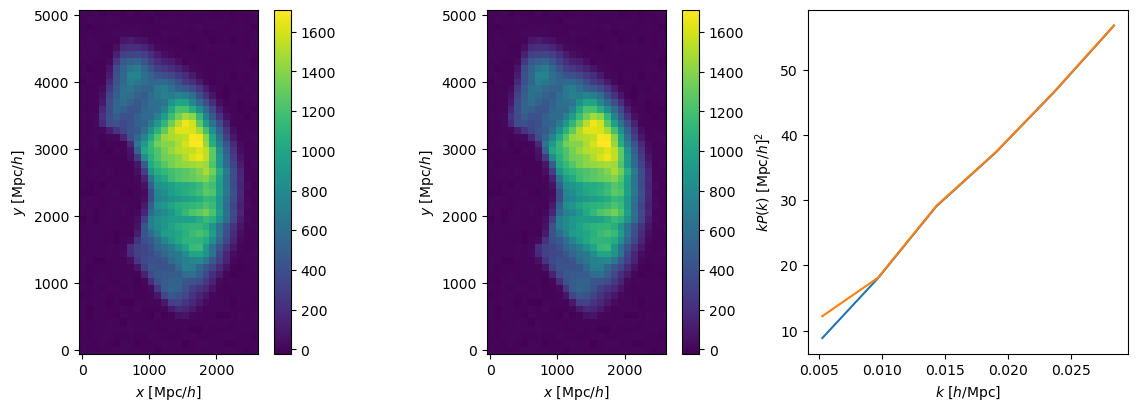

In [3]:
from montecosmo.plot import plot_mesh, plot_pow

axis = 2
ind = 1.
# count_obs  = model.masked2mesh(truth['obs'])
# count_obs2 = model2.masked2mesh(truth2['obs'])

count_obs  = truth['obs']
count_obs2 = truth2['obs']

plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(131)
plot_mesh(count_obs, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(132)
plot_mesh(count_obs2, model2.box_shape, ind, axis)
plt.colorbar()

plt.subplot(133)
kpow = model.spectrum(delta_obs)
kpow2 = model2.spectrum(delta_obs2)
plot_pow(*kpow);
plot_pow(*kpow2);
# plt.savefig("./figs_png/omega/apauto1_noise00.png", dpi=300, bbox_inches='tight')

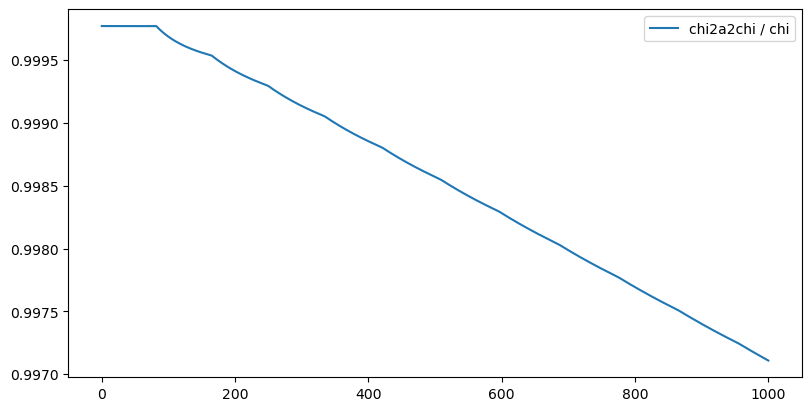

In [26]:
from montecosmo.nbody import a2chi, chi2a
from montecosmo.bricks import get_cosmology

cosmo = get_cosmology(Omega_m=0.3, sigma8=0.8)

chis = np.linspace(0., 1000, 10000)
fn = lambda chis: a2chi(model.cosmo_fid, chi2a(cosmo, chis))

plt.figure(figsize=(8, 4), layout='constrained')
plt.plot(chis, fn(chis) / chis, label="chi2a2chi / chi")
plt.legend()
# plt.plot(chis, chis, label="chi")


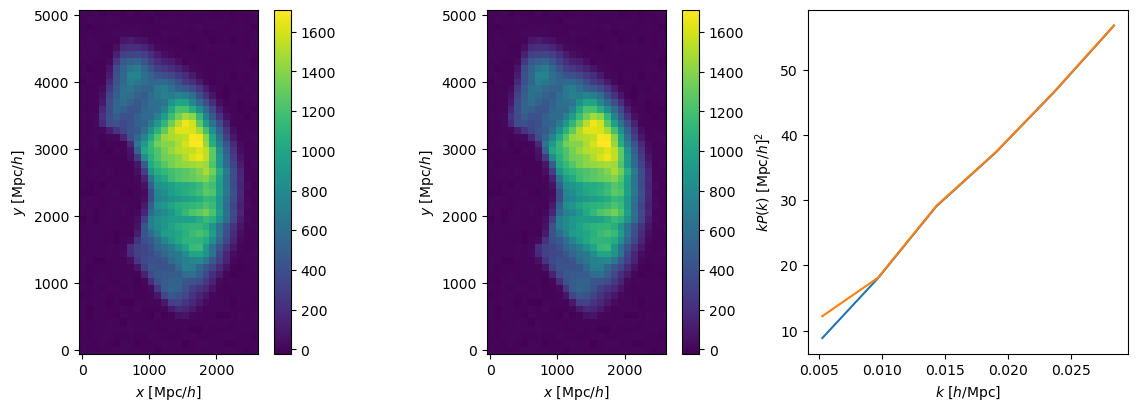

In [3]:
from montecosmo.plot import plot_mesh, plot_pow

axis = 2
ind = 1.
# count_obs  = model.masked2mesh(truth['obs'])
# count_obs2 = model2.masked2mesh(truth2['obs'])

count_obs  = truth['obs']
count_obs2 = truth2['obs']

plt.figure(figsize=(12, 4), layout='constrained')
plt.subplot(131)
plot_mesh(count_obs, model.box_shape, ind, axis)
plt.colorbar()

plt.subplot(132)
plot_mesh(count_obs2, model2.box_shape, ind, axis)
plt.colorbar()

plt.subplot(133)
kpow = model.spectrum(delta_obs)
kpow2 = model2.spectrum(delta_obs2)
plot_pow(*kpow);
plot_pow(*kpow2);
# plt.savefig("./figs_png/omega/apauto1_noise00.png", dpi=300, bbox_inches='tight')

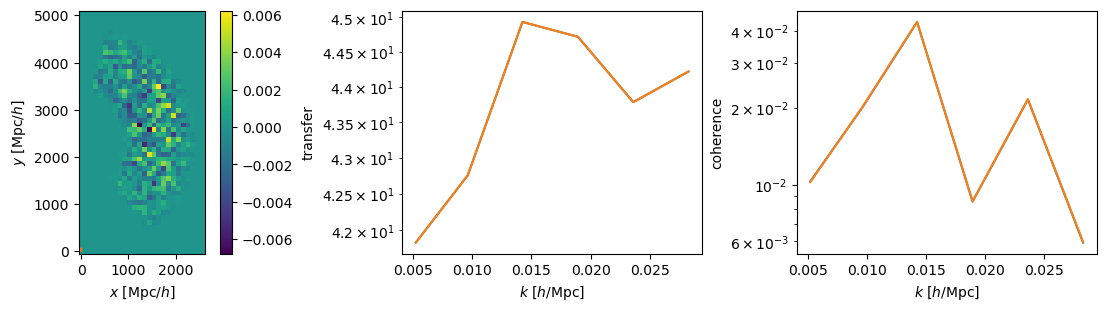

In [ ]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kptc = model.powtranscoh(mesh_true, delta_obs)
mesh_true2 = jnp.fft.irfftn(truth2['init_mesh'])
kptc2 = model2.powtranscoh(mesh_true2, delta_obs2)

plt.figure(figsize=(12, 3), layout='constrained')
plot_powtranscoh(*kptc)
plot_powtranscoh(*kptc2)
plt.subplot(131)
ind = 1.
plot_mesh(count_obs2-count_obs, model.box_shape, ind, axis)
plt.colorbar();
# plt.savefig("./figs_png/omega/apauto1_noise_diff00.png", dpi=300, bbox_inches='tight')

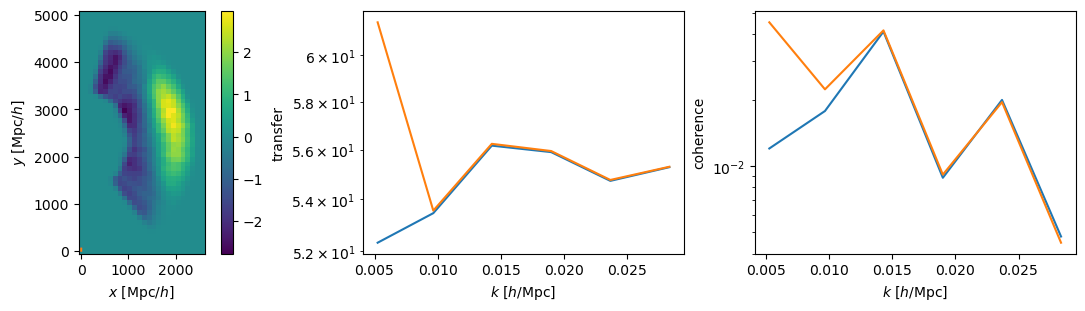

In [4]:
from montecosmo.plot import plot_mesh, plot_pow, plot_powtranscoh
mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kptc = model.powtranscoh(mesh_true, delta_obs)
mesh_true2 = jnp.fft.irfftn(truth2['init_mesh'])
kptc2 = model2.powtranscoh(mesh_true2, delta_obs2)

plt.figure(figsize=(12, 3), layout='constrained')
plot_powtranscoh(*kptc)
plot_powtranscoh(*kptc2)
plt.subplot(131)
ind = 1.
plot_mesh(count_obs2-count_obs, model.box_shape, ind, axis)
plt.colorbar();
# plt.savefig("./figs_png/omega/apauto1_noise_diff00.png", dpi=300, bbox_inches='tight')

In [5]:
count_obs.mean(), count_obs2.mean(),   count_obs.mean() / count_obs2.mean()

(Array(283.13395363, dtype=float64),
 Array(283.04422009, dtype=float64),
 Array(1.00031703, dtype=float64))

In [6]:
# from montecosmo.bricks import lin_power_mesh
# from montecosmo.nbody import paint, read, deconv_paint, lpt

# mesh = jr.normal(jr.key(0), model.mesh_shape)
# pmesh = lin_power_mesh(model.cosmo_fid, model.mesh_shape, model.box_shape)
# # mesh = jnp.fft.irfftn(jnp.fft.rfftn(mesh) * pmesh**.5)
# mesh = jnp.fft.rfftn(mesh) * pmesh**.5
# pos = [np.linspace(0, m, p, endpoint=False) for m, p in zip(model.mesh_shape, model.ptcl_shape)]
# pos = jnp.stack(np.meshgrid(*pos, indexing='ij'), axis=-1).reshape(-1, 3)

# dpos, vel = lpt(model.cosmo_fid, mesh, pos, a=0.5, lpt_order=2, paint_order=1)

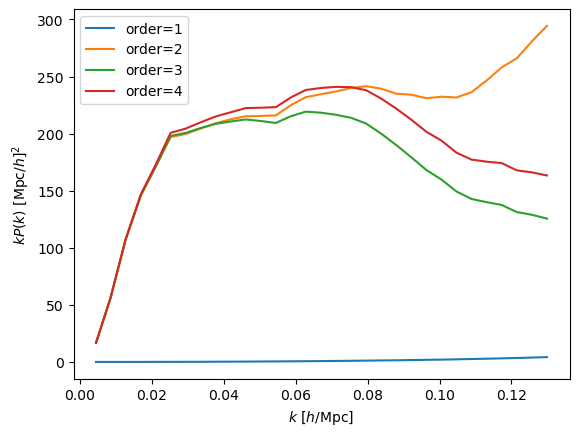

In [81]:
for i in range(1, 5):
    delta = paint(pos + dpos, tuple(model.mesh_shape), order=i)
    delta = deconv_paint(delta, order=i)
    kpow = model.spectrum(delta)
    plot_pow(*kpow, label=f"order={i}")
plt.legend();

## Perform the inference

### Warmup the field only

In [ ]:
n_samples, n_runs, n_chains = 128, 12, 8
tune_mass = True
overwrite = True
# overwrite = False

params_init = jit(vmap(partial(model.kaiser_post, delta_obs=delta_obs, scale_field=1/10)))(jr.split(jr.key(45), n_chains))    
params_init2 = jit(vmap(partial(model2.kaiser_post, delta_obs=delta_obs2)))(jr.split(jr.key(45), n_chains))

if not os.path.exists(save_path+"_warm_state.p") or overwrite:
    print("Warming up...")
    model.reset()
    model.condition({'obs': truth['obs']} | model.loc_fid, from_base=True)
    model.block()

    from montecosmo.samplers import get_mclmc_warmup
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, 
                                desired_energy_var=1e-6, diagonal_preconditioning=False)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), {k: params_init[k] for k in ['init_mesh_']})
    pdump(state, save_path+"_warm_state.p")
    pdump(config, save_path+"_warm_conf.p")
else:
    state = pload(save_path+"_warm_state.p")
    config = pload(save_path+"_warm_conf.p")

# obs = ['obs','b1','b2','bs2','bn2','bnp','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','Omega_m','sigma8','b1','b2','bs2','bn2','ngbar']
# obs = ['obs','b1','b2','bs2','bn2','fNL','ngbar']
# obs = ['obs','b2','bs2','bn2','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','bnp','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','fNL','b2','bs2','bn2','bnp','alpha_iso','alpha_ap']
obs = ['obs','fNL','b2','bs2','bn2','bnp','alpha_iso','alpha_ap']
# obs = ['obs','fNL','b2','bs2','bn2','bnp','ngbar','alpha_iso','alpha_ap']
# obs = ['obs','alpha_iso','alpha_ap']
# obs = ['obs', 'ngbar']
obs = {k: truth[k] for k in obs}

model.reset()
model.condition(obs, from_base=True)
model.render()
model.block()

params_warm = params_init | state.position
params_warm = {k: params_warm[k] for k in params_warm.keys() - model.data.keys()}

norsd
norsd
norsd
norsd
Warming up...
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd


In [ ]:
from montecosmo.plot import plot_pow, plot_trans, plot_coh, plot_powtranscoh
from montecosmo.bricks import lin_power_interp

mesh_true = jnp.fft.irfftn(truth['init_mesh'])
kpow_true = model.spectrum(mesh_true)
kpow_fid = kpow_true[0], lin_power_interp(model.cosmo_fid)(kpow_true[0])
kptc_obs = model.powtranscoh(mesh_true, delta_obs)
kptcs_init = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_init)
kptcs_init2 = vmap(lambda x: model2.powtranscoh(mesh_true, model2.reparam(x, fourier=False)['init_mesh']))(params_init2)
kptcs_warm = vmap(lambda x: model.powtranscoh(mesh_true, model.reparam(x, fourier=False)['init_mesh']))(params_warm)

norsd
norsd
norsd


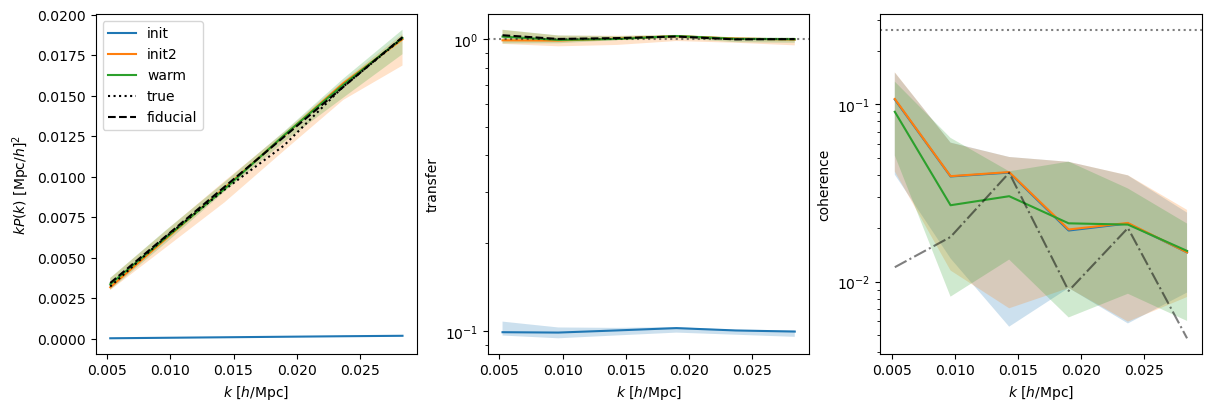

In [ ]:
prob = 0.95

plt.figure(figsize=(12, 4), layout='constrained')
def plot_kptcs(kptcs, label=None):
    plot_powtranscoh(*kptcs, fill=prob)
    plot_powtranscoh(*tree.map(lambda x: jnp.median(x, 0), kptcs), label=label)

plot_kptcs(kptcs_init, label='init')
plot_kptcs(kptcs_init2, label='init2')
plot_kptcs(kptcs_warm, label='warm')

plt.subplot(131)
plot_pow(*kpow_true, 'k:', label='true')
plot_pow(*kpow_fid, 'k--', label='fiducial')
plt.legend()
plt.subplot(132)
plot_trans(kpow_true[0], (kpow_fid[1] / kpow_true[1])**.5, 'k--', label='fiducial')
plt.axhline(1., linestyle=':', color='k', alpha=0.5)
plt.subplot(133)
plot_coh(kptc_obs[0], kptc_obs[3], 'k-.', alpha=0.5, label='obs');
plt.axhline(model.wind_mesh.mean(), linestyle=':', color='k', alpha=0.5)
plt.savefig(save_path+f'_init_warm.png')   

### Warmup all parameters and run

In [ ]:
# jconfig.update("jax_debug_nans", True)
from tqdm import tqdm
from montecosmo.samplers import get_mclmc_warmup, get_mclmc_run
from blackjax.adaptation.mclmc_adaptation import MCLMCAdaptationState
overwrite = True
# overwrite = False

params_warm['init_mesh_']  = jnp.broadcast_to(truth['init_mesh_'], jnp.shape(params_warm['init_mesh_']))

if not os.path.exists(save_path+"_warm2_state.p") or overwrite:
    print("Warming up...")
    warmup_fn = jit(vmap(get_mclmc_warmup(model.logpdf, n_steps=2**14, config=None, # 2**13
                                        # desired_energy_var=2e-7, diagonal_preconditioning=tune_mass)))
                                        desired_energy_var=2e-8, diagonal_preconditioning=tune_mass)))
    state, config = warmup_fn(jr.split(jr.key(43), n_chains), params_warm)

    print("ss: ", config.step_size)

    eval_per_ess = 1e3
    ss = jnp.median(config.step_size)
    config = MCLMCAdaptationState(L=0.4 * eval_per_ess/2 * ss, 
                                step_size=ss, 
                                inverse_mass_matrix=jnp.median(config.inverse_mass_matrix, 0))
    config = tree.map(lambda x: jnp.broadcast_to(x, (n_chains, *jnp.shape(x))), config)
    
    pdump(state, save_path+"_warm2_state.p")
    pdump(config, save_path+"_conf.p")
    start = 1

    print("ss: ", config.step_size[0])
    print("L: ", config.L[0])
    from jax.flatten_util import ravel_pytree
    flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
    print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))
    print(tree.map(vmap(lambda x: jnp.isnan(x).sum()), state.position))
    

elif not os.path.exists(save_path+"_last_state.p") or overwrite:
    state = pload(save_path+"_warm2_state.p")
    config = pload(save_path+"_conf.p")
    start = 1

else:
    state = pload(save_path+"_last_state.p")
    config = pload(save_path+"_conf.p")
    start = 100 ###########


print("Running...")
run_fn = jit(vmap(get_mclmc_run(model.logpdf, n_samples, thinning=64, progress_bar=False)))
key = jr.key(42)

end = start + n_runs - 1
for i_run in tqdm(range(start, end + 1)):
    print(f"run {i_run}/{end}")
    key, run_key = jr.split(key, 2)
    state, samples = run_fn(jr.split(run_key, n_chains), state, config)
    
    print("MSE per dim:", jnp.mean(samples['mse_per_dim'], 1), '\n')
    jnp.savez(save_path+f"_{i_run}.npz", **samples)
    pdump(state, save_path+"_last_state.p")



Warming up...
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd
norsd
kai
norsd


In [ ]:
!scancel 5637141

In [ ]:
config = pload(save_path+"_conf.p")
state = pload(save_path+"_last_state.p")

print("ss: ", config.step_size)
print("L: ", config.L)
from jax.flatten_util import ravel_pytree
flat, unrav_fn = ravel_pytree(tree.map(lambda x:x[0], state.position))
print("inv_mm:", unrav_fn(config.inverse_mass_matrix[0]))